# Prediction Models



In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statistics import mode
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

### Read in the Train and Test csv files

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

### Train spilt to train and val 

In [6]:
#splitting
train, val = train_test_split(train, train_size=0.70, test_size=0.30, 
                              stratify=train['readmitted'], random_state=42)

In [7]:
#what is the shape of the three
train.shape, val.shape, test.shape

((43504, 43), (18645, 43), (19422, 43))

In [16]:
#sample of data
train.sample(2)

,race,gender,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_2,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,age_group,discharge,med_spec
56148,Caucasian,Female,1,42,0,9,0,0,0,Respiratory,...,No,No,No,No,0,0,0,Senior,Home,Emergency/Trauma
44357,AfricanAmerican,Female,4,66,6,24,0,0,0,Other,...,No,No,No,No,1,1,1,Adult,Home,Other


### Target
Our target is a binary class. Majority class occurs at 52% frequency

In [8]:
#what is the frequency of our target readmitted
train['readmitted'].value_counts(normalize=True)

0    0.525377
1    0.474623
Name: readmitted, dtype: float64

### Pandas profiling
Will give a report of the zeros and warnings wthin our data

In [9]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

In [13]:
#saving the profile to generate a html report
#profile.to_file("Diabetes_profile.html")
train['number_emergency'].value_counts()

0     38543
1      3371
2       873
3       316
4       155
5        90
6        41
7        27
8        20
9        16
10       13
12        7
13        6
11        5
20        4
18        3
19        3
14        2
76        1
25        1
46        1
15        1
16        1
21        1
22        1
64        1
29        1
Name: number_emergency, dtype: int64

In [15]:
train['number_inpatient'].value_counts()

0     28827
1      8453
2      3244
3      1412
4       675
5       359
6       215
7       110
8        62
9        51
10       29
11       25
12       16
13       11
14        6
15        6
17        1
16        1
18        1
Name: number_inpatient, dtype: int64

### Select Features

In [19]:
# The "readmitted" column is the target
target = 'readmitted'

# Get a dataframe with all train columns except the target 
train_features = train.drop(columns=[target,])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed', 'race', 'gender', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'age_group', 'discharge', 'med_spec']


In [20]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Logistic Regression Model

In [33]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeL = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)
)

# Fit on train
pipeL.fit(X_train, y_train)

# Score on validation
print ('Validation Accruacy', pipeL.score(X_val, y_val))

# Predict on test
y_predL = pipeL.predict(X_val)


Validation Accruacy 0.6163582729954411


### Confusion matrix for Logistic Regression Model

In [34]:

# checking the confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, y_predL))

[[7393 2403]
 [4750 4099]]


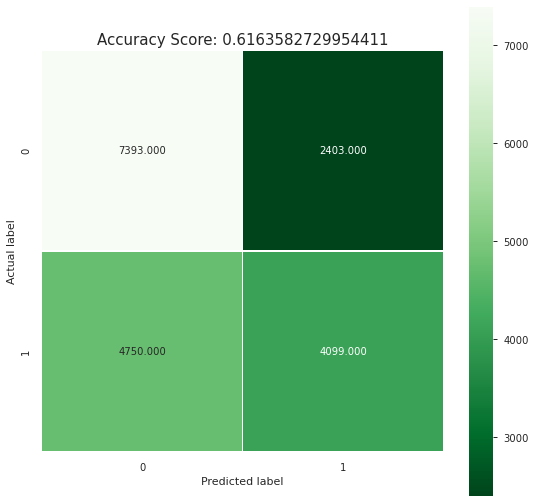

In [46]:
#Plot
import seaborn as sns

plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix(y_val, y_predL), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Greens_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(pipeL.score(X_val, y_val))
plt.title(all_sample_title, size = 15);

### Plotting Coefficients

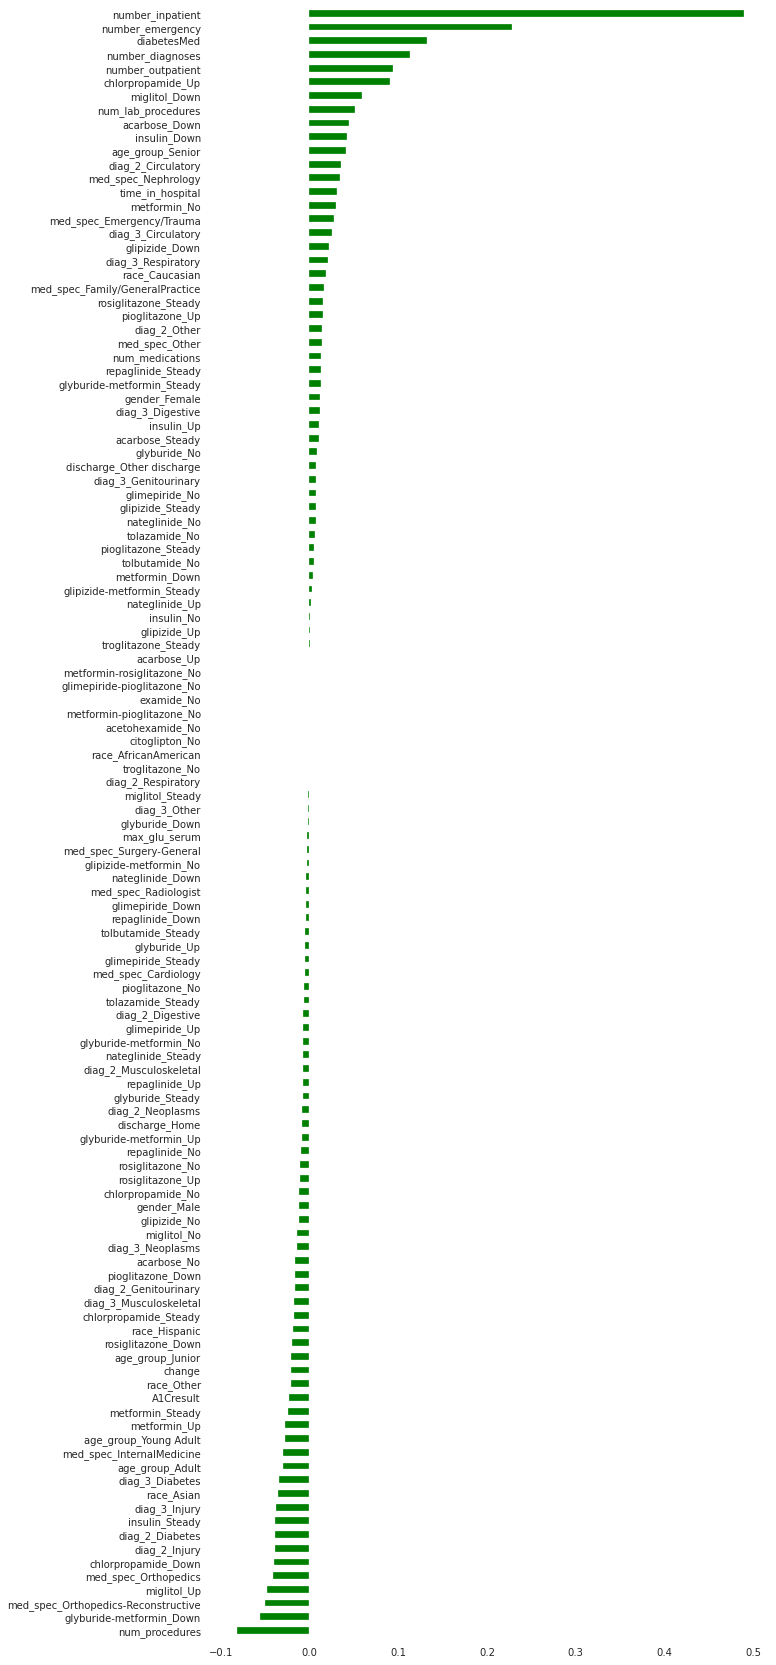

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

modeL = pipeL.named_steps['logisticregression']
encoderL = pipeL.named_steps['onehotencoder']
encoded_columnsL = encoderL.transform(X_val).columns
coefficientsL = pd.Series(modeL.coef_[0], encoded_columnsL)
plt.figure(figsize=(10,30))
coefficientsL.sort_values().plot.barh(color='green');

### Classification Report

In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_val,y_predL, target_names = ['NO', 'YES']))

              precision    recall  f1-score   support

          NO       0.61      0.75      0.67      9796
         YES       0.63      0.46      0.53      8849

    accuracy                           0.62     18645
   macro avg       0.62      0.61      0.60     18645
weighted avg       0.62      0.62      0.61     18645



### ROC

In [49]:
# Checking the performance of model using ROC curve plots
scr_L =pipeL.decision_function(X_val)

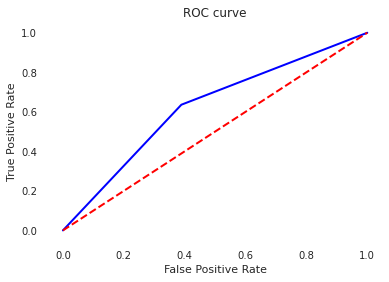

In [51]:
##Computing false and true positive rates
from sklearn.metrics import roc_curve

fpr, tpr,_=roc_curve(pipeL.predict(X_train),y_train,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()
##Creating the ROC,
plt.plot(fpr, tpr, color='blue',
 lw=2, label='ROC curve')
##Finding FPR and TPR,
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
##Splecifying the label and title,
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

# Random Forest Model

In [38]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipeR = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeR.fit(X_train, y_train)
print('Validation Accuracy', pipeR.score(X_val, y_val))
y_predR = pipeR.predict(X_val)

Validation Accuracy 0.6171091445427729


### Features of Importance

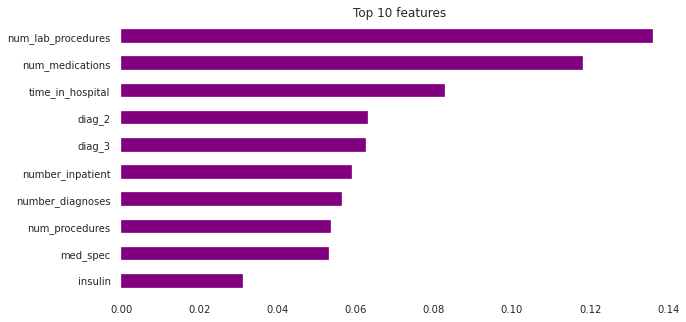

In [31]:
# Get feature importances
rf = pipeR.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='purple');

### Confusion matrix for Random Forest Model

In [39]:

#Printing the confusion matrix,
print(confusion_matrix(y_val,y_predR))

[[6843 2953]
 [4186 4663]]


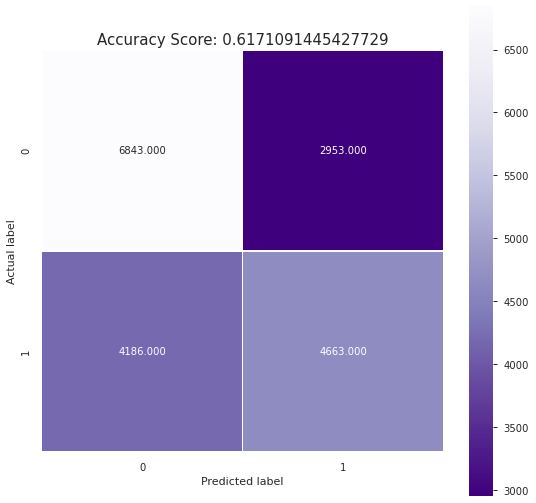

In [47]:
plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix(y_val,y_predR), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Purples_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(pipeR.score(X_val,y_val))
plt.title(all_sample_title, size = 15);

In [81]:

#Calculating the score,
scr_R=pipeR.predict_proba(X_val)[:,1]
rfpr, rtpr, thresholds = roc_curve(y_val, scr_R)

# XGBOOST Model

In [52]:
#!pip install xgboost
from xgboost import XGBClassifier

pipeXG = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeXG.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['race', 'gender', 'diag_2', 'diag_3',
                                      'metformin', 'repaglinide', 'nateglinide',
                                      'chlorpropamide', 'glimepiride',
                                      'acetohexamide', 'glipizide', 'glyburide',
                                      'tolbutamide', 'pioglitazone',
                                      'rosiglitazone', 'acarbose', 'miglitol',
                                      'troglitazone', 'tolazamide', 'examide',
                                      'citoglipton', 'insulin',
                                      'glyburide-metformin'...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=

In [53]:
# getting the accuracy score
from sklearn.metrics import accuracy_score
y_predXG = pipeXG.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_predXG))# it is better than the random and logistic Models

Validation Accuracy 0.621989809600429


# Permutation Importance

In [58]:
#Note that I don't need to put the model in the pipeline
transformersP = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformedP = transformersP.fit_transform(X_train)
X_val_transformedP = transformersP.transform(X_val)

modelP = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
modelP.fit(X_train_transformedP, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [59]:
# Ignore warnings
#! pip install eli5

import eli5
from eli5.sklearn import PermutationImportance

permuterP = PermutationImportance(
    modelP, #What is the model?
    scoring='accuracy', #What scoring parameter do you want to use?
    n_iter=5, #How many of random shuffles? 
    random_state=42 
)

permuterP.fit(X_val_transformedP, y_val)

/home/parent/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/parent/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


PermutationImportance(estimator=RandomForestClassifier(n_jobs=-1,
                                                       random_state=42),
                      random_state=42, scoring='accuracy')

In [60]:
feature_names = X_val.columns.tolist()
pd.Series(permuterP.feature_importances_, feature_names).sort_values()

rosiglitazone              -0.000676
metformin                  -0.000279
nateglinide                -0.000215
metformin-pioglitazone      0.000000
metformin-rosiglitazone     0.000000
glimepiride-pioglitazone    0.000000
glipizide-metformin         0.000000
tolbutamide                 0.000000
citoglipton                 0.000000
examide                     0.000000
acetohexamide               0.000000
troglitazone                0.000000
chlorpropamide              0.000011
miglitol                    0.000011
acarbose                    0.000011
change                      0.000011
gender                      0.000032
tolazamide                  0.000054
glyburide                   0.000129
repaglinide                 0.000139
glimepiride                 0.000161
glipizide                   0.000215
glyburide-metformin         0.000225
pioglitazone                0.000772
race                        0.000815
max_glu_serum               0.001695
diabetesMed                 0.001942
t

In [61]:
# 2. Display permutation importances
eli5.show_weights(
    permuterP, 
    top=None, # No limit: show permutation importances for all features
    feature_names=feature_names # must be a list
)

Weight,Feature
0.0521 ± 0.0026,number_inpatient
0.0090 ± 0.0034,number_outpatient
0.0085 ± 0.0021,number_emergency
0.0078 ± 0.0030,number_diagnoses
0.0057 ± 0.0030,num_procedures
0.0057 ± 0.0014,num_lab_procedures
0.0049 ± 0.0029,num_medications
0.0036 ± 0.0015,med_spec
0.0035 ± 0.0014,diag_2
0.0033 ± 0.0015,discharge


In [62]:
print('Shape before removing features:', X_train.shape)

Shape before removing features: (43504, 42)


In [63]:
minimum_importance = 0 
mask = permuterP.feature_importances_ > minimum_importance #apply conditional statement to all elements of array
features2 = X_train.columns[mask] #Select columns where mask is true (permutation score > 0)
X_train2 = X_train[features2] #Save new X_train Looks like there is no change

In [67]:
print('Shape after removing features:', X_train.shape)# Looks like there is no change

Shape after removing features: (43504, 42)


In [68]:
X_val2 = X_val[features2]

pipeP = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeP.fit(X_train2, y_train)
print('Validation Accuracy', pipeP.score(X_val2, y_val))

Validation Accuracy 0.616519174041298


In [73]:
column  = 'number_inpatient'

# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without number_inpatient: 0.5919013140252078
Validation Accuracy with number_inpatient: 0.6171091445427729
Drop-Column Importance for number_inpatient: 0.025207830517565033


# Decision Tree Model

In [74]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeD = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(random_state=42)
)

# Fit on train
pipeD.fit(X_train, y_train)

# Score on validation
print ('Train Accuracy', pipeD.score(X_train, y_train))
print ('Validation Accuracy', pipeD.score(X_val, y_val))

# Predict on test
y_preD = pipeD.predict(X_val)

Train Accuracy 1.0
Validation Accuracy 0.5503352105122017


In [90]:
#Reducing the complexity of the tree
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeDT = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(min_samples_leaf = 100, random_state=42) # added min_samples_leaf
)

# Fit on train
pipeDT.fit(X_train, y_train)

# Score on validation
print ('Train Accuracy', pipeDT.score(X_train, y_train))
print ('Validation Accuracy', pipeDT.score(X_val, y_val))

# Predict on test
y_pred = pipeDT.predict(X_val)

Train Accuracy 0.6404238690695109
Validation Accuracy 0.6039152587825154


In [ ]:
#plotting the decision tree
import graphviz
from sklearn.tree import export_graphviz

modelD = pipeDT.named_steps['decisiontreeclassifier']
encoderD = pipeDT.named_steps['onehotencoder']
encoded_columnsD = encoderD.transform(X_val).columns

dot_data = export_graphviz(modelD, 
                           out_file=None, 
                           max_depth=3, 
                           feature_names=encoded_columnsD,
                           class_names=modelD.classes_, 
                           impurity=True, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

# Model Comparisson

In [91]:
fpr_log, tpr_log, thresholds = roc_curve(y_val, y_predL)#logistic regression
fpr_rf, tpr_rf, thresholds = roc_curve(y_val, y_predR)#random forest classifier
fpr_XG, tpr_XG, thresholds = roc_curve(y_val, y_predXG)#XGBoost
fpr_DT, tpr_DT, thresholds = roc_curve(y_val,y_pred )#DecisionTree


<ipython-input-92-ac9cf8c27c0b>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


Text(0, 0.5, 'True Positive Rate')

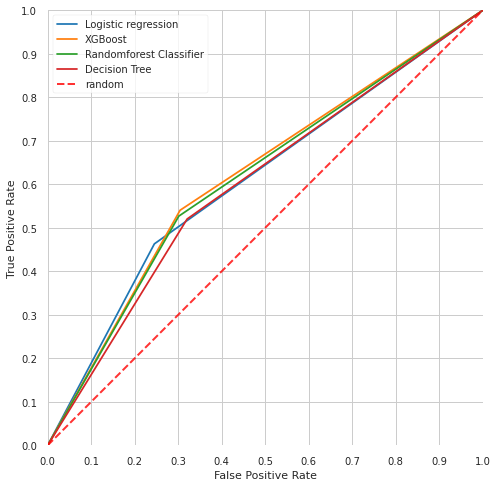

In [92]:
#compare the ROC curve between different models
plt.figure(figsize=(8,8))
plt.plot(fpr_log, tpr_log, label='Logistic regression')
plt.plot(fpr_XG, tpr_XG, label='XGBoost')
plt.plot(fpr_rf, tpr_rf, label='Randomforest Classifier')
plt.plot(fpr_DT, tpr_DT, label='Decision Tree')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='random', alpha=.8)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid()
plt.legend()
plt.axes().set_aspect('equal')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [94]:
print("Accuracy of Logistic Regression Model:" ,pipeL.score(X_val, y_val)*100)
print("Accuracy of Random Forest Classification Model: ", pipeR.score(X_val, y_val)*100)
print("Accuracy of XGBoost Model: ", pipeXG.score(X_val, y_val)*100)
print("Accuracy of Decision Tree Model: ", pipeDT.score(X_val, y_val)*100)


Accuracy of Logistic Regression Model: 61.63582729954411
Accuracy of Random Forest Classification Model:  61.71091445427729
Accuracy of XGBoost Model:  62.1989809600429
Accuracy of Decision Tree Model:  60.39152587825154


# Conclusion

The aim of the project was to predict hospital readmission within the 10 years the data was collected. After changing the target to a binary class and making the models it clear that:

1. The best Model was XgBosst with an AUC score of 62.2%

2. Accuracy of the models is close the lowest being the decision tree with 60.4%

3. The accuracy score can be improved with more data processing and cleaning.
